# 과제3 : 상품 카테고리별 수요 예측 및 재고 관리 인사이트
시간에 따른 상품 카테고리별 판매 트렌드를 분석하고, 계절성 패턴을 파악하여 향후 수요 예측과 재고 관리 전략을 수립하세요.

In [13]:
# ============================================================
# 상품 카테고리별 수요 예측 & 재고 관리
# 1. 시간에 따른 카테고리별 판매 트렌드
# 2. 계절성 패턴 파악
# 3. 향후 수요 예측
# 4. 재고 관리 전략 수립
# ============================================================

[트렌드 시작 시점 자동선정] 2016-10-01 이후 데이터 사용 (매출>0 카테고리 6개 이상)


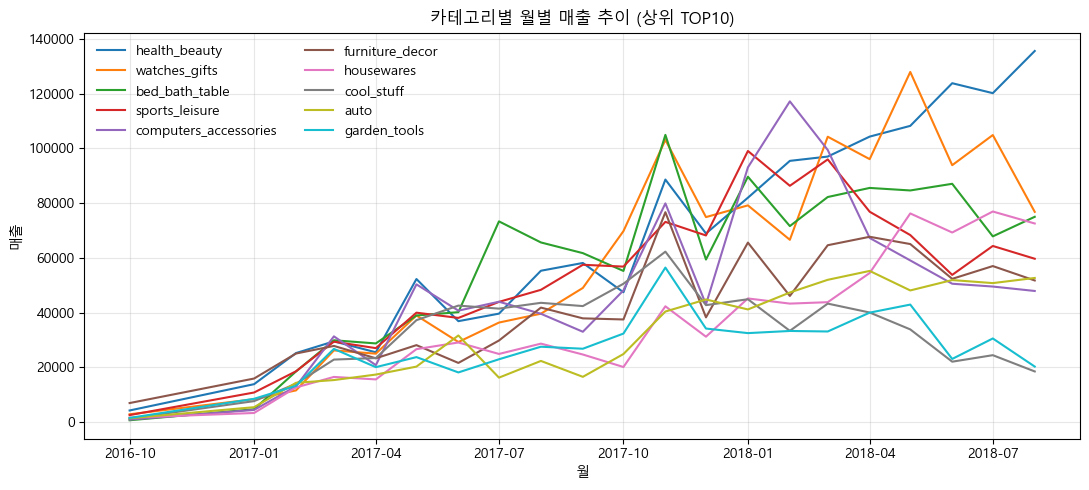

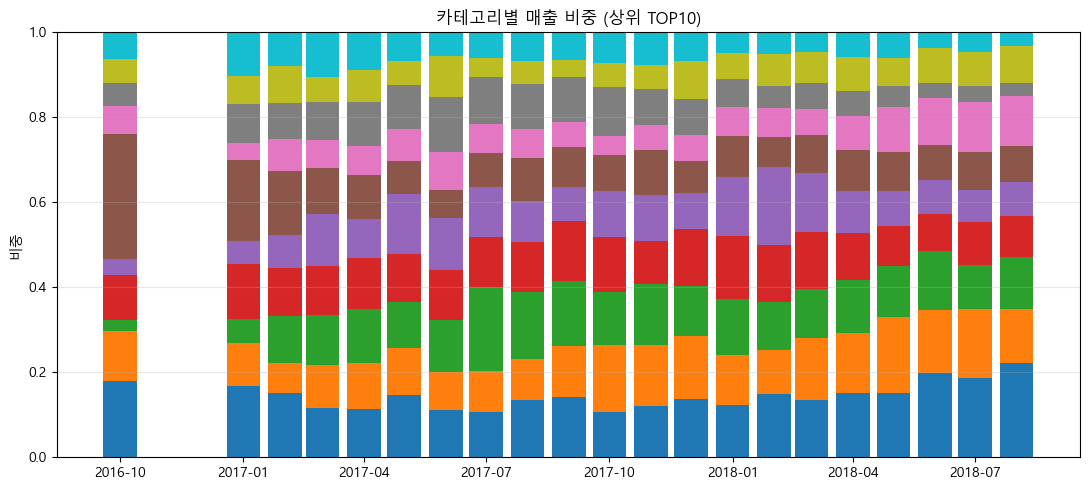

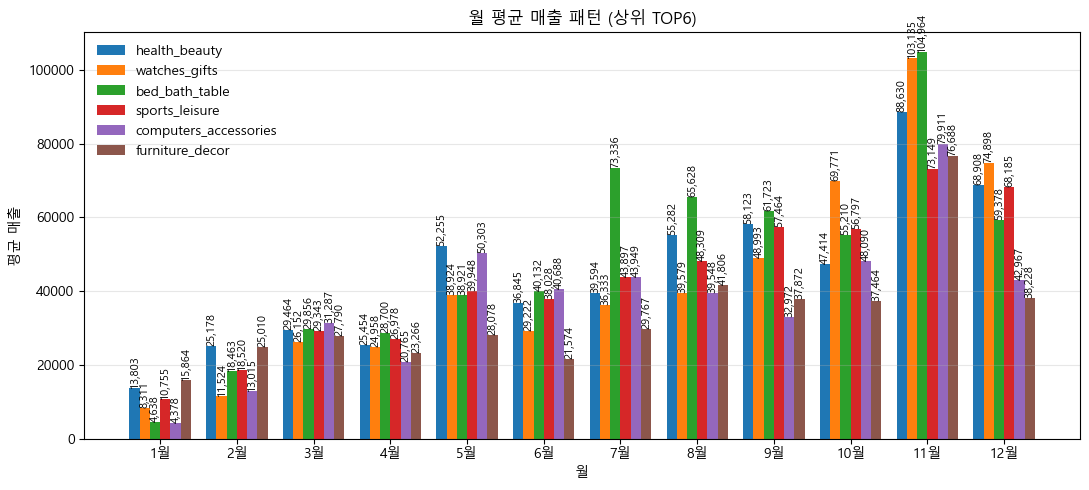

=== 계절성 강도(간이) 상위 ===
             category  seasonality_strength
         garden_tools                  0.50
           housewares                  0.34
           cool_stuff                  0.31
       bed_bath_table                  0.31
      furniture_decor                  0.31
        health_beauty                  0.29
                 auto                  0.27
        watches_gifts                  0.23
computers_accessories                  0.21
       sports_leisure                  0.15


In [14]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.patches as mpatches

# 기본 설정
warnings.filterwarnings('ignore', category=UserWarning)
try:
    plt.rcParams['font.family'] = 'Malgun Gothic'
except Exception:
    pass
plt.rcParams['axes.unicode_minus'] = False
pd.options.display.float_format = lambda x: f"{x:,.2f}"

# csv
orders   = pd.read_csv('./olist_orders_dataset.csv')
items    = pd.read_csv('./olist_order_items_dataset.csv')
products = pd.read_csv('./olist_products_dataset.csv')
category = pd.read_csv('./product_category_name_translation.csv')

# 날짜형
for col in ['order_purchase_timestamp', 'order_delivered_customer_date']:
    if col in orders.columns:
        orders[col] = pd.to_datetime(orders[col], errors='coerce')

# 배송완료 주문만
orders_ok = orders[(orders['order_status']=='delivered') & orders['order_purchase_timestamp'].notna()].copy()

# 카테고리 영문화
products = products.merge(category, on='product_category_name', how='left')
products['category_en'] = (
    products['product_category_name_english']
    .fillna(products['product_category_name'])
    .fillna('unknown')
)

# 주문-아이템-상품 결합
oi = (
    items.merge(orders_ok[['order_id','order_purchase_timestamp','order_delivered_customer_date']], on='order_id', how='inner')
        .merge(products[['product_id','category_en']], on='product_id', how='left')
)

oi['ym']  = oi['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()
oi['date'] = oi['order_purchase_timestamp'].dt.date
oi['qty'] = 1  # 아이템 행=수량 1
INCLUDE_FREIGHT = True
if INCLUDE_FREIGHT and 'freight_value' in oi.columns:
    oi['rev'] = oi['price'] + oi['freight_value']
else:
    oi['rev'] = oi['price']

# 월별 집계
mth = (
    oi.groupby(['ym','category_en'])
      .agg(orders=('order_id','nunique'), units=('qty','sum'), revenue=('rev','sum'))
      .reset_index()
)

# 상위 카테고리(매출 기준)
TOP_N = 10
top_cats = (
    mth.groupby('category_en')['revenue'].sum()
       .sort_values(ascending=False)
       .head(TOP_N).index.tolist()
)


# 1) 시간 트렌드 & 비중 
# --------------------
mt = mth[mth['category_en'].isin(top_cats)].copy()
share = mt.pivot(index='ym', columns='category_en', values='revenue').fillna(0).sort_index()

# 초기 이상치 제거: 매출>0인 상위카테고리 수가 충분한 첫 달부터 시작
k_present = (share > 0).sum(axis=1)
cut_k = min(6, TOP_N)
valid_idx = k_present[k_present >= cut_k].index
start_ym = valid_idx[0] if len(valid_idx)>0 else share.index.min()

mt_v = mt[mt['ym'] >= start_ym].copy()
share_v = share.loc[share.index >= start_ym]
print(f"[트렌드 시작 시점 자동선정] {start_ym.date()} 이후 데이터 사용 (매출>0 카테고리 {cut_k}개 이상)")

# 라인: 월별 매출 추이
plt.figure(figsize=(11,5))
for c in top_cats:
    s = mt_v[mt_v['category_en']==c].set_index('ym')['revenue'].sort_index()
    if len(s) > 0:
        plt.plot(s.index, s.values, label=c)
plt.title('카테고리별 월별 매출 추이 (상위 TOP10)')
plt.xlabel('월'); plt.ylabel('매출')
plt.legend(loc='upper left', ncol=2, frameon=False)
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# 누적 막대: 카테고리별 매출 비중(월별)
plt.figure(figsize=(11,5))
bottom = np.zeros(len(share_v))
idx = share_v.index
for c in top_cats:
    vals = share_v[c].reindex(idx).fillna(0).values
    total = share_v.sum(axis=1).values
    pct = np.divide(vals, total, out=np.zeros_like(vals, dtype=float), where=total>0)
    plt.bar(idx, pct, bottom=bottom, width=25, align='center')
    bottom += pct
plt.title('카테고리별 매출 비중 (상위 TOP10)')
plt.ylabel('비중'); plt.ylim(0,1); plt.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()


# 2) 계절성 패턴
# -------------
mth_all = mt.copy()
mth_all['year'] = mth_all['ym'].dt.year
m_per_year = mth_all.groupby(['year'])['ym'].nunique()
full_years = m_per_year[m_per_year==12].index.tolist()
mth_full = mth_all[mth_all['year'].isin(full_years)].copy()

# 월 평균 (full years only, revenue 기준)
mth_full['month'] = mth_full['ym'].dt.month
month_mean = (
    mth_full.groupby(['month','category_en'])['revenue']
            .mean().reset_index()
)

# 막대 + 수치 라벨(TOP 6)
view_cats = top_cats[:6]
plt.figure(figsize=(11,5))
width = 0.8/len(view_cats)
x = np.arange(1,13)
for i, c in enumerate(view_cats):
    vals = (month_mean[month_mean['category_en']==c]
              .set_index('month')['revenue']
              .reindex(range(1,13)).fillna(0).values)
    bars = plt.bar(x + (i - len(view_cats)/2)*width + width/2, vals, width=width, label=c)
    for rect in bars:
        h = rect.get_height()
        if h>0:
            plt.text(rect.get_x()+rect.get_width()/2, h, f"{h:,.0f}", ha='center', va='bottom', fontsize=8, rotation=90)
plt.title('월 평균 매출 패턴 (상위 TOP6)')
plt.xlabel('월'); plt.ylabel('평균 매출')
plt.xticks(ticks=np.arange(1,13), labels=[f"{i}월" for i in range(1,13)])
plt.legend(frameon=False); plt.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()


# 간이 계절성 강도: 1 - Var(residual)/Var(total)
seas_strength = []
for c in top_cats:
    s = mth_all[mth_all['category_en']==c].set_index('ym')['revenue'].sort_index()
    if len(s) < 18:
        seas_strength.append((c, np.nan)); continue
    seas = s.groupby(s.index.month).transform('mean')
    resid = s - seas
    denom = np.var(s.values)
    num = np.var(resid.values)
    sc = np.nan if denom<=0 else max(0, 1 - (num/denom))
    seas_strength.append((c, sc))
seas_df = pd.DataFrame(seas_strength, columns=['category','seasonality_strength']).sort_values('seasonality_strength', ascending=False)
print('=== 계절성 강도(간이) 상위 ===')
print(seas_df.head(10).to_string(index=False))


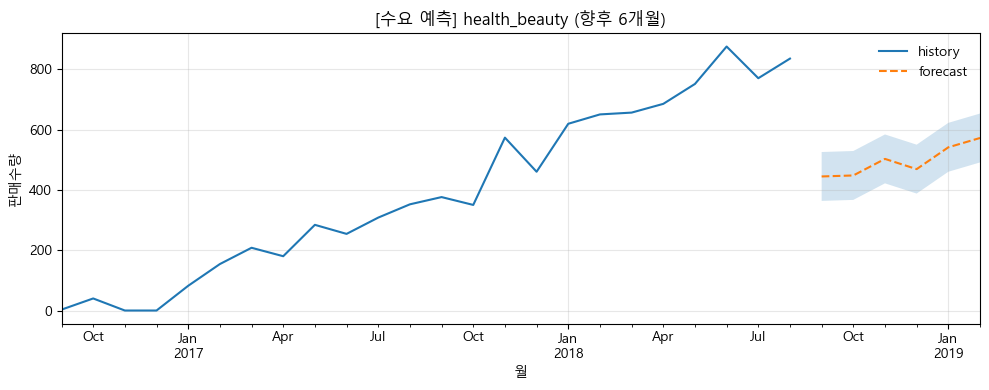

         카테고리       월   예측수요  하한(95%)  상한(95%)
health_beauty 2018-09 444.37   363.34   525.39
health_beauty 2018-10 447.67   366.64   528.69
health_beauty 2018-11 502.57   421.54   583.59
health_beauty 2018-12 468.67   387.64   549.69
health_beauty 2019-01 540.97   459.94   621.99
health_beauty 2019-02 571.87   490.84   652.89


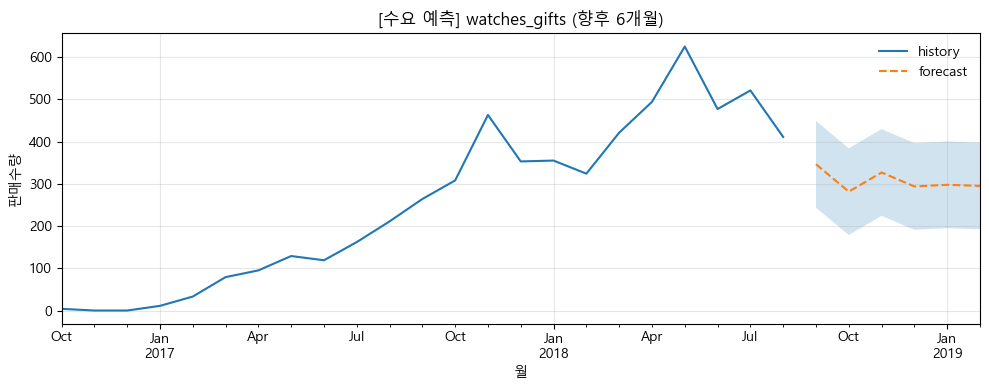

         카테고리       월   예측수요  하한(95%)  상한(95%)
watches_gifts 2018-09 346.27   243.58   448.95
watches_gifts 2018-10 281.47   178.78   384.15
watches_gifts 2018-11 326.77   224.08   429.45
watches_gifts 2018-12 293.77   191.08   396.45
watches_gifts 2019-01 297.67   194.98   400.35
watches_gifts 2019-02 294.97   192.28   397.65


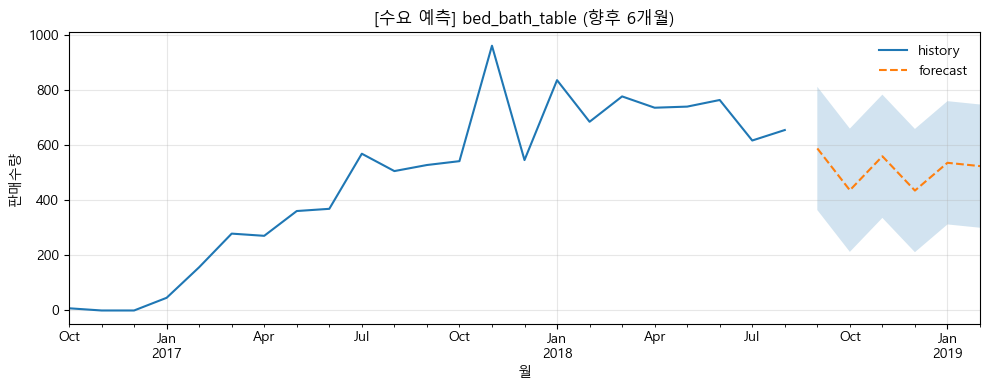

          카테고리       월   예측수요  하한(95%)  상한(95%)
bed_bath_table 2018-09 588.27   364.56   811.97
bed_bath_table 2018-10 436.47   212.76   660.17
bed_bath_table 2018-11 559.77   336.06   783.47
bed_bath_table 2018-12 435.27   211.56   658.97
bed_bath_table 2019-01 536.07   312.36   759.77
bed_bath_table 2019-02 524.07   300.36   747.77

=== 재고 운영 가이드 (상위 3카테고리) ===


,카테고리,평균일수요,수요표준편차,수요CV,평균리드타임(일),피크월,피크증가율(%),권장z,권장안전재고,권장ROP
0,bed_bath_table,18.35,12.45,0.68,12.99,11.00,116.80,1.65,73.80,312.20
1,health_beauty,15.72,10.81,0.69,12.08,11.00,96.60,1.65,61.80,251.70
2,watches_gifts,10.26,7.97,0.78,12.81,11.00,141.80,1.65,46.90,178.30


[발주/재고 운용 체크리스트]
- 수요가 들쑥날쑥하거나 계절 타는 상품: 안전재고 여유를 늘리고, 성수기 2~4주 전에 미리 발주
- 배송/이동 시간 단축(전진 배치·예약 배송 등) 시: 재주문 기준선을 낮춰 창고 점유율 감소
- 비수기: 안전재고 여유를 낮추고, 느리게 팔리는 상품은 발주량 축소/중단 → 묶음·할인으로 소진


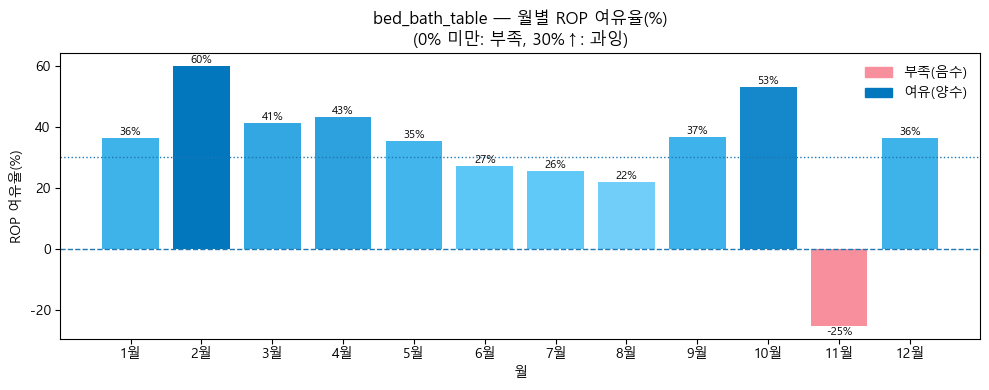

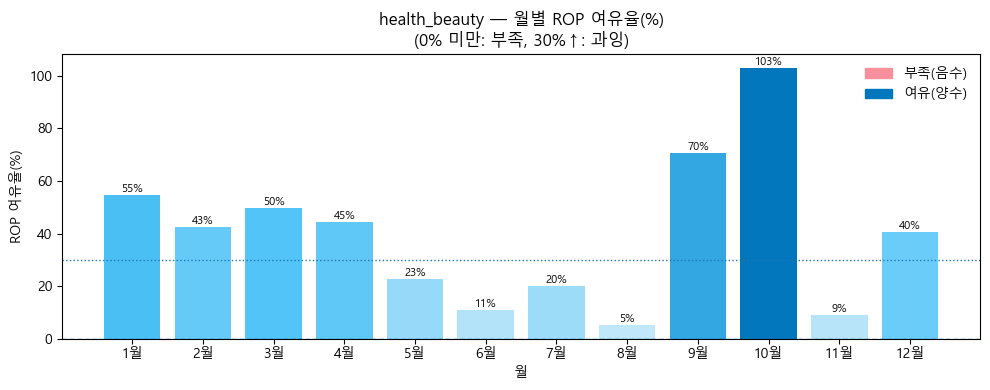

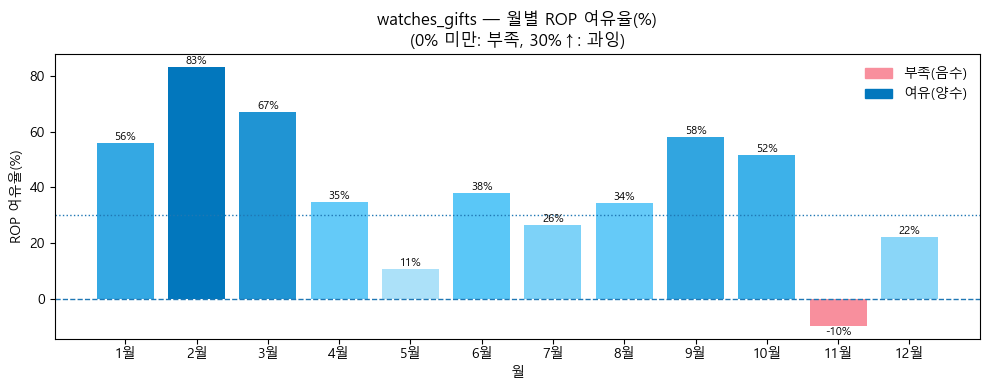

In [15]:
# 3) 수요 예측
# -----------
sel = top_cats[:3]
h = 6

for c in sel:
    s = mt[mt['category_en']==c].set_index('ym')['units'].sort_index()
    if len(s) < 12:
        print(f"[예측 생략] {c}: 데이터 부족"); continue
    s = s.asfreq('MS').fillna(0)
    seasonal = s.groupby(s.index.month).transform('mean')
    trend = s.rolling(3).mean()

    back_yhat = 0.6*seasonal + 0.4*trend
    resid = (s - back_yhat).dropna().iloc[-12:]
    sigma = float(resid.std()) if len(resid)>3 else float((s - s.mean()).std())

    last = s.index.max().to_period('M')
    future_idx = pd.period_range(last+1, periods=h, freq='M').to_timestamp()

    yhat = []
    last_trend = float(trend.iloc[-1]) if not np.isnan(trend.iloc[-1]) else float(s.mean())
    month_mean_units = s.groupby(s.index.month).mean()
    for ts in future_idx:
        base = float(month_mean_units.get(ts.month, s.mean()))
        yhat.append(0.6*base + 0.4*last_trend)
    yhat = pd.Series(yhat, index=future_idx)

    ci_low = yhat - 1.96*sigma
    ci_hi  = yhat + 1.96*sigma

    plt.figure(figsize=(10,4))
    s.tail(24).plot(label='history')
    yhat.plot(style='--', label='forecast')
    plt.fill_between(yhat.index, ci_low.values, ci_hi.values, alpha=0.2)
    plt.title(f"[수요 예측] {c} (향후 {h}개월)")
    plt.xlabel('월'); plt.ylabel('판매수량')
    plt.grid(alpha=0.3); plt.legend(frameon=False); plt.tight_layout(); plt.show()

    out = pd.DataFrame({'카테고리':c, '월':yhat.index.strftime('%Y-%m'),
                        '예측수요':yhat.values, '하한(95%)':ci_low.values, '상한(95%)':ci_hi.values})
    print(out.to_string(index=False))

# 4) 재고 전략
# ------------

# 일별 수요
daily = oi.groupby(['date','category_en'])['qty'].sum().reset_index()

# 카테고리별 리드타임(L, 일)
tmp = (
    oi[['order_id','category_en']].drop_duplicates()
      .merge(orders_ok[['order_id','order_purchase_timestamp','order_delivered_customer_date']], on='order_id', how='left')
)
tmp['lead_days'] = (tmp['order_delivered_customer_date'] - tmp['order_purchase_timestamp']).dt.total_seconds()/86400
L = tmp.groupby('category_en')['lead_days'].mean().rename('평균리드타임(일)')

# 일별 통계
stat = daily.groupby('category_en')['qty'].agg(평균일수요='mean', 수요표준편차='std')
stat['수요CV'] = stat['수요표준편차'] / stat['평균일수요'].replace(0,np.nan)

# 피크월/증가율 (revenue 기준 월평균 사용)
mm = month_mean.pivot(index='category_en', columns='month', values='revenue')
peak_info = []
for c in top_cats:
    if c in mm.index and mm.loc[c].notna().any():
        row = mm.loc[c]
        peak_m = int(row.idxmax())
        mean_v = float(row.mean())
        peak_v = float(row.max())
        inc = (peak_v - mean_v)/mean_v*100 if mean_v>0 else np.nan
    else:
        peak_m, inc = np.nan, np.nan
    peak_info.append((c, peak_m, inc))
peak_df = pd.DataFrame(peak_info, columns=['category_en','피크월','피크증가율(%)']).set_index('category_en')

# z 추천 (CV + 계절성)
seas_map = seas_df.set_index('category')['seasonality_strength']

def recommend_z(cv, seas):
    if np.isnan(cv):  # 기본 95%
        base = 1.645
    elif cv <= 0.50:
        base = 1.28      # 90%
    elif cv <= 0.80:
        base = 1.645     # 95%
    else:
        base = 2.05      # 97.5%
    if not np.isnan(seas) and seas >= 0.5:
        base += 0.2
    return round(base, 3)

z_reco = []
for c in top_cats[:3]:
    cv = float(stat.loc[c,'수요CV']) if c in stat.index else np.nan
    seas = float(seas_map.get(c, np.nan))
    z_reco.append((c, recommend_z(cv, seas)))
z_df = pd.DataFrame(z_reco, columns=['category_en','권장z']).set_index('category_en')

# 통합 & 안전재고/ROP
inv = pd.concat([stat, L, peak_df, z_df], axis=1).dropna(subset=['평균리드타임(일)'])
inv = inv.loc[inv.index.intersection(top_cats[:3])].copy()
inv['권장안전재고'] = (inv['권장z'] * inv['수요표준편차'] * np.sqrt(inv['평균리드타임(일)'].clip(lower=1)))
inv['권장ROP']   = (inv['평균일수요'] * inv['평균리드타임(일)'].clip(lower=1)) + inv['권장안전재고']

inv_view = (
    inv.reset_index()
       .rename(columns={'category_en':'카테고리'})
       [['카테고리','평균일수요','수요표준편차','수요CV','평균리드타임(일)',
         '피크월','피크증가율(%)','권장z','권장안전재고','권장ROP']]
       .round({'평균일수요':2,'수요표준편차':2,'수요CV':2,'평균리드타임(일)':2,'피크증가율(%)':1,
               '권장안전재고':1,'권장ROP':1})
)
print('\n=== 재고 운영 가이드 (상위 3카테고리) ===')
try:    display(inv_view)
except: print(inv_view.to_string(index=False))

print("[발주/재고 운용 체크리스트]")
print("- 수요가 들쑥날쑥하거나 계절 타는 상품: 안전재고 여유를 늘리고, 성수기 2~4주 전에 미리 발주")
print("- 배송/이동 시간 단축(전진 배치·예약 배송 등) 시: 재주문 기준선을 낮춰 창고 점유율 감소")
print("- 비수기: 안전재고 여유를 낮추고, 느리게 팔리는 상품은 발주량 축소/중단 → 묶음·할인으로 소진")

# -------------------------------------------------
#  재고 부족/과잉 구간 그래프
#   정의: 월별 ROP 여유율(%) = (권장ROP - (해당월 평균일수요 * L)) / (해당월 평균일수요 * L) * 100
#   - 음수: 리드타임 수요 대비 ROP 부족 → "재고 부족 위험"
#   - +30% 이상: 과잉 버퍼 → "재고 과잉 위험"
# -------------------------------------------------
# 월별 평균 "일 수요" (units/day), 월-of-year 기준

neg_cmap = LinearSegmentedColormap.from_list("neg_grad", ["#f88f9d", "#ef5350", "#c62828"])  # 부족(음수)
pos_cmap = LinearSegmentedColormap.from_list("sky_grad", ["#cdebfa", "#4fc3f7", "#0277bd"])  # 여유(0 이상)

daily_df = daily.copy()
daily_df['dt'] = pd.to_datetime(daily_df['date'])
daily_df['month'] = daily_df['dt'].dt.month
monthly_daily_mean = daily_df.groupby(['category_en','month'])['qty'].mean()

for c in inv.index:
    L_days  = float(inv.loc[c, '평균리드타임(일)'])
    ROP_rec = float(inv.loc[c, '권장ROP'])  # 너 코드에 맞춰 '권장ROP' 사용 (다르면 ROP 변수명으로 바꿔)
    # 월별 평균 일수요
    dbar_m = monthly_daily_mean.loc[c] if (c in monthly_daily_mean.index.get_level_values(0)) else None
    if dbar_m is None or len(dbar_m) == 0:
        continue

    exp_L_demand = dbar_m * L_days
    margin_pct = (ROP_rec - exp_L_demand) / exp_L_demand.replace(0, np.nan) * 100
    margin_pct = margin_pct.replace([np.inf, -np.inf], np.nan).fillna(0)
    vals = margin_pct.reindex(range(1, 13)).values

    # 값에 따른 색상(음수=빨강 그라데이션, 0 이상=하늘색 그라데이션)
    neg_vals = vals[vals < 0]
    pos_vals = vals[vals >= 0]
    neg_norm = Normalize(vmin=neg_vals.min() if neg_vals.size else -1, vmax=0)
    pos_norm = Normalize(vmin=0, vmax=pos_vals.max() if pos_vals.size else 1)
    colors = [neg_cmap(neg_norm(v)) if v < 0 else pos_cmap(pos_norm(v)) for v in vals]

    # 그리기
    plt.figure(figsize=(10, 4))
    bars = plt.bar(range(1, 13), vals, color=colors, edgecolor='none')

    # 기준선
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.axhline(30, linestyle=':', linewidth=1)

    # 값 라벨(음수는 막대 위쪽에 붙이기 위해 va=top)
    for rect in bars:
        h = rect.get_height()
        x = rect.get_x() + rect.get_width()/2
        va = 'bottom' if h >= 0 else 'top'
        plt.text(x, h, f"{h:.0f}%", ha='center', va=va, fontsize=8)

    # 간단 범례
    lg_neg = mpatches.Patch(color=neg_cmap(neg_norm(neg_vals.min() if neg_vals.size else -1)), label="부족(음수)")
    lg_pos = mpatches.Patch(color=pos_cmap(pos_norm(pos_vals.max() if pos_vals.size else 1)), label="여유(양수)")
    plt.legend(handles=[lg_neg, lg_pos], frameon=False, loc='upper right')

    plt.title(f"{c} — 월별 ROP 여유율(%)\n(0% 미만: 부족, 30%↑: 과잉)")
    plt.xlabel('월'); plt.ylabel('ROP 여유율(%)')
    plt.xticks(ticks=np.arange(1, 13), labels=[f"{i}월" for i in range(1, 13)])
    plt.tight_layout(); plt.show()

In [16]:
# 5) 재고 관리 전략
# ----------------

# 일별 수요(수량)
oi['date'] = oi['order_purchase_timestamp'].dt.date
daily = (oi.groupby(['date','category_en'])['qty'].sum().reset_index())
# 카테고리별 리드타임(일) 근사: 주문-배송 완료 (아이템→주문 결합)
tmp = (oi[['order_id','category_en']].drop_duplicates()
          .merge(orders_ok[['order_id','order_purchase_timestamp','order_delivered_customer_date']], on='order_id', how='left'))
tmp['lead_days'] = (tmp['order_delivered_customer_date'] - tmp['order_purchase_timestamp']).dt.total_seconds()/86400

L = tmp.groupby('category_en')['lead_days'].mean().rename('L').to_frame()
dstat = (daily.groupby('category_en')['qty']
              .agg(dbar='mean', dstd='std')
              .reset_index()).merge(L, left_on='category_en', right_index=True, how='left')

dstat = dstat[dstat['category_en'].isin(sel)]  # 예측 대상과 동일 그룹만 샘플 계산
z = 1.645  # 95%
dstat['safety_stock'] = (z * dstat['dstd'] * np.sqrt(dstat['L'].clip(lower=1)))
dstat['ROP'] = (dstat['dbar'] * dstat['L'].clip(lower=1)) + dstat['safety_stock']

print("=== 재고 전략 (예: 상위 3개 카테고리) ===")
print("가정: 일별 수요/평균 리드타임 기반, 서비스레벨=95%")
inv_table = (
    dstat[['category_en','dbar','dstd','L','safety_stock','ROP']]
      .rename(columns={
          'category_en': '카테고리',
          'dbar':        '하루 평균 판매량',
          'dstd':        '판매량 표준편차',
          'L':           '평균 배송 소요일',
          'safety_stock':'안전재고',
          'ROP':         '재주문 시점(수량)'
      })
      .round(2)
)

display(inv_table) 

print("\n[전략 가이드]")
print("1) 성수기 직전에는 안전재고를 한시적으로 상향하여 확보를 합니다.")
print("2) 배송 소요일이 긴 품목은 사전 발주를 진행하고 일부 지점에 재고를 전진 배치함으로써 소요일을 줄여 재고 부담을 낮춥니다.")
print("3) 비수기에는 안전재고를 완만히 낮추고, 회전 속도가 느린 품목은 단계적으로 축소하는 방향으로 진행합니다.")
print("4) 지연이 잦은 지역은 여유 재고를 조금 더 확보하고 배송이 빠른 지역은 재고를 많이 쌓지 않고 소량으로 자주 발주해 수요를 맞춥니다.")


=== 재고 전략 (예: 상위 3개 카테고리) ===
가정: 일별 수요/평균 리드타임 기반, 서비스레벨=95%


,카테고리,하루 평균 판매량,판매량 표준편차,평균 배송 소요일,안전재고,재주문 시점(수량)
7,bed_bath_table,18.35,12.45,12.99,73.82,312.15
43,health_beauty,15.72,10.81,12.08,61.81,251.66
73,watches_gifts,10.26,7.97,12.81,46.91,178.31



[전략 가이드]
1) 성수기 직전에는 안전재고를 한시적으로 상향하여 확보를 합니다.
2) 배송 소요일이 긴 품목은 사전 발주를 진행하고 일부 지점에 재고를 전진 배치함으로써 소요일을 줄여 재고 부담을 낮춥니다.
3) 비수기에는 안전재고를 완만히 낮추고, 회전 속도가 느린 품목은 단계적으로 축소하는 방향으로 진행합니다.
4) 지연이 잦은 지역은 여유 재고를 조금 더 확보하고 배송이 빠른 지역은 재고를 많이 쌓지 않고 소량으로 자주 발주해 수요를 맞춥니다.
